This script preprocesses the merged dataset, handles outliers, and performs imputation.

Note: The entire process involved univariate analysis of all features using histograms, boxplots, and summary statistics 
pre and post imputation. It also involved checking data quality and identifying unusual households. These steps have 
been omitted since there are over 70 variables, and showing all of them would not be insightful for the reader. 

This code contains only the parts that affected the decision-making process (needed to reproduce the study). For comprehensive information (full code used for 
the study), please refer to "5) Exploratory Data Analysis and Imputation" in the 'full-code' folder.

Data source:
- Merged data: '4) final_merged_data.csv'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

# Load the final merged dataframe
df_merged = pd.read_csv('4) final_merged_data.csv', parse_dates=['timestamp'])

# Create a dataframe with one row per household for static characteristics
df_households = df_merged.groupby('household_id').first().reset_index()

In [2]:
missing_values = df_households.isnull().sum()
pd.set_option('display.max_rows', None)

print("Number of missing values in each column (sorted in descending order):")
print(missing_values.sort_values(ascending=False))
print("\nTotal number of missing values in the dataset:")
print(missing_values.sum())

Number of missing values in each column (sorted in descending order):
insulation_floor_insulation                     315
insulation_wall_insulation                      271
insulation_hot_water_tank_insulation_lagging    183
insulation_roof_or_loft_insulation              157
kettle_fixed_schedule                           114
ironing_fixed_schedule                          106
washer-dryer_combined_ownership                 103
washer-dryer_combined_timer_use                 103
tumble_dryer_timer_use                           78
tumble_dryer_ownership                           78
washing_machine_timer_use                        71
washing_machine_ownership                        71
electric_space_heating_timer_use                 68
electric_space_heating_ownership                 68
lighting_fixed_schedule                          63
dishwasher_timer_use                             63
dishwasher_ownership                             63
electric_oven_fixed_schedule                  

In [3]:
# Drop insulation feature (high % of values missing and also did not improve model performance later)
df_households.drop(columns=[col for col in df_households.columns if col.startswith('insulation')], inplace=True)
df_merged.drop(columns=[col for col in df_merged.columns if col.startswith('insulation')], inplace=True)

In [4]:
# Categorise variables (including count variables)
numerical_vars = ['consumption', 'household_size', 'male_occupants', 'female_occupants', 
                  'count_children', 'count_adult', 'count_rooms', 'count_bedrooms'] + \
                 ['count_' + bulb_type + '_bulbs' for bulb_type in ['low_efficiency', 'high_efficiency']] + \
                 ['total_refrigeration_units', 'count_fridges_and_freezers', 'count_fluorescent_tubes'] + \
                 ['count_' + appliance for appliance in ['cooking_appliances', 'laundry_appliances', 'kitchen_appliances',
                'heating_water_appliances', 'entertainment_devices', 'computing_devices', 'energy_saving_devices']] + \
                 ['count_tv', 'tv_energy_score', 'smart_meter_interaction_score']

categorical_vars = ['work_from_home', 'interest_in_renewable_energy', 'interest_in_microgeneration', 
                    'climate_change_concern', 'lifestyle_environment',
                    'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'] + \
                   [col for col in df_merged.columns if col.endswith('_timer_use')]

binary_vars = ['electric_central_heating', 'uses_electric_heater'] + \
              [col for col in df_merged.columns if col.startswith('heating_')] + \
              [col for col in df_merged.columns if col.endswith('_fixed_schedule')] + \
              [col for col in df_merged.columns if col.startswith('ownership_')] + \
              [col for col in df_merged.columns if col.startswith('housing_')] + \
              [col for col in df_merged.columns if col.endswith('_ownership')]

# Define count variables
count_vars = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'count_adult',
    'count_rooms', 'count_bedrooms', 'count_high_efficiency_bulbs', 'count_low_efficiency_bulbs', 
    'count_fluorescent_tubes', 'count_fridges_and_freezers', 
    'count_tv', 'count_cooking_appliances', 'count_laundry_appliances', 
    'count_kitchen_appliances', 'count_heating_water_appliances', 'count_entertainment_devices', 
    'count_computing_devices', 'count_energy_saving_devices'
]

# Define variables of interest and functions for visualization and summary

In [5]:
# Define variables of interest
vars_of_interest = ['count_rooms', 'count_bedrooms', 'count_high_efficiency_bulbs', 'count_fridges_and_freezers']

def plot_and_summarize(df, vars, title):
    print(f"\n{title}")
    for var in vars:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[var], kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.show()
        
        print(f"\nSummary statistics for {var}:")
        print(df[var].describe())

def plot_timeseries(x, y, title, ylabel):
    plt.figure(figsize=(12, 5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Pre-processing visualization and summary


Pre-processing


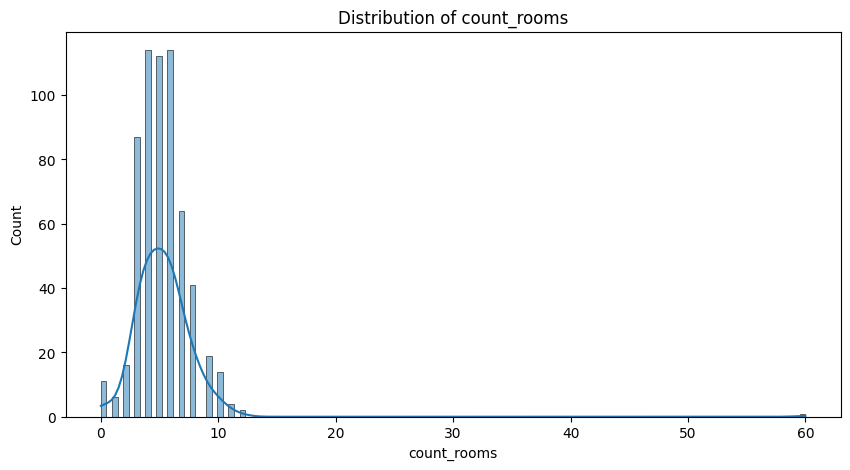


Summary statistics for count_rooms:
count    605.000000
mean       5.312397
std        3.038919
min        0.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       60.000000
Name: count_rooms, dtype: float64


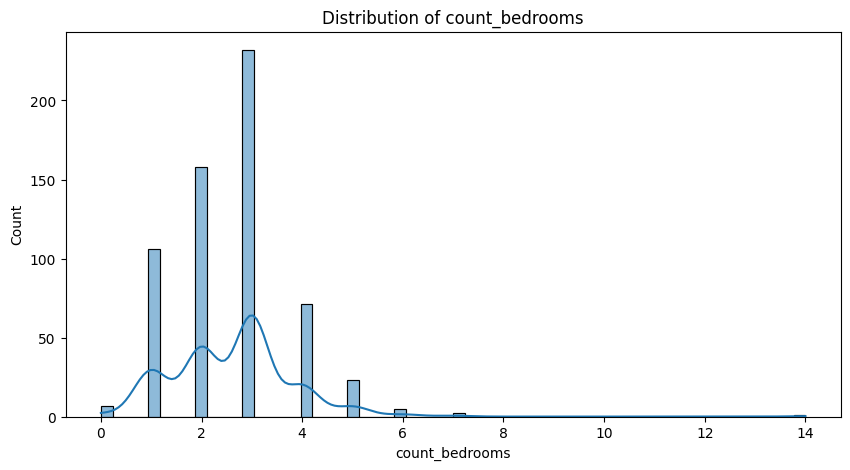


Summary statistics for count_bedrooms:
count    605.000000
mean       2.603306
std        1.227980
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       14.000000
Name: count_bedrooms, dtype: float64


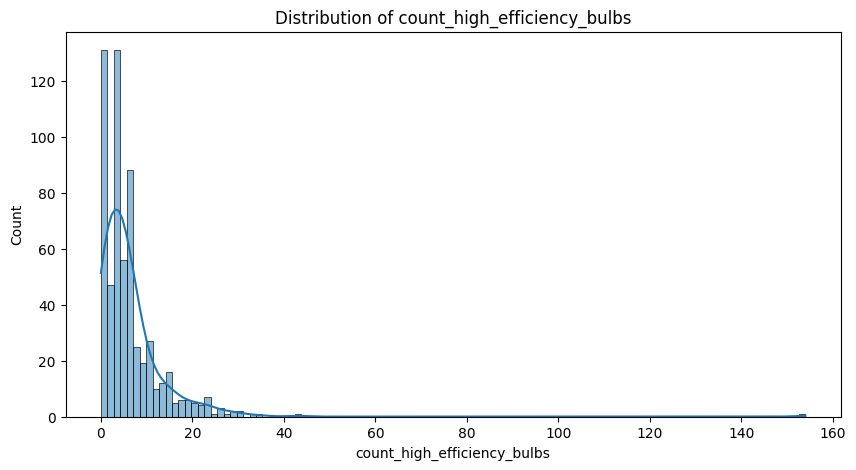


Summary statistics for count_high_efficiency_bulbs:
count    608.000000
mean       6.202303
std        8.591989
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max      154.000000
Name: count_high_efficiency_bulbs, dtype: float64


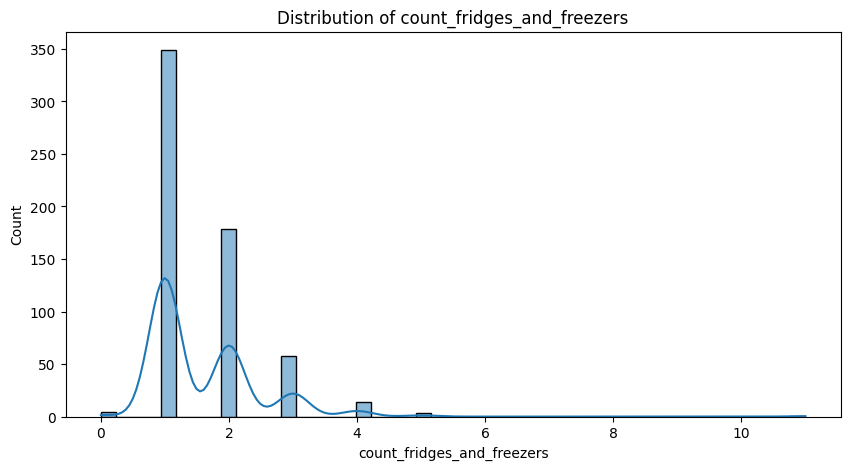


Summary statistics for count_fridges_and_freezers:
count    608.000000
mean       1.583882
std        0.890849
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: count_fridges_and_freezers, dtype: float64


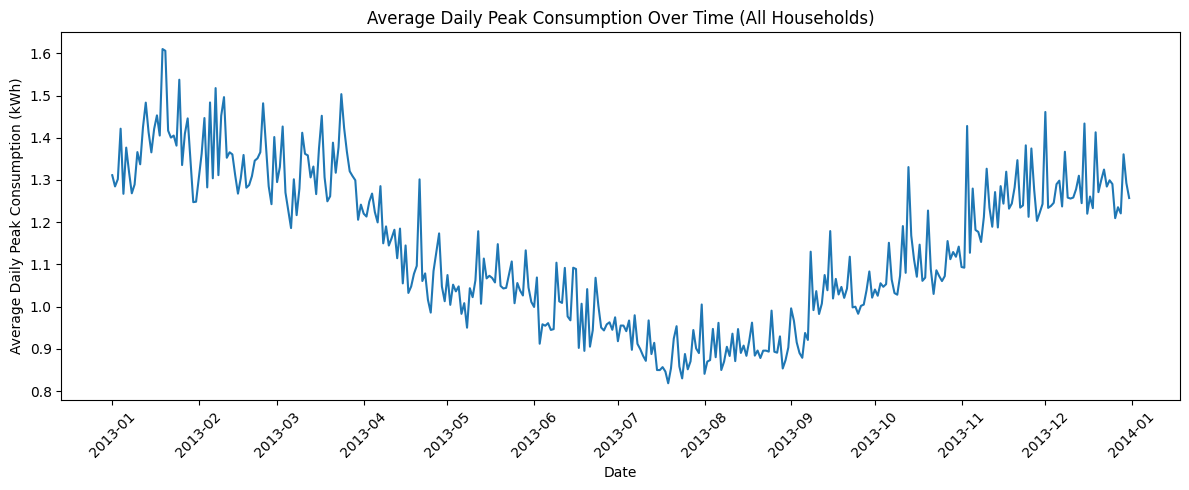

In [6]:
plot_and_summarize(df_households, vars_of_interest, "Pre-processing")

# Calculate daily peak consumption
daily_peak = df_merged.groupby(['household_id', df_merged['timestamp'].dt.date])['consumption'].max().reset_index()
avg_daily_peak = daily_peak.groupby('timestamp')['consumption'].mean()

# Pre-imputation time series plot
plot_timeseries(avg_daily_peak.index, avg_daily_peak.values, 
                'Average Daily Peak Consumption Over Time (All Households)', 
                'Average Daily Peak Consumption (kWh)')

# Outlier handling

In [7]:
# Fix for D1022
# Likely data entry error. Changed 60 rooms to 6 for this residential household.
df_households.loc[df_merged['household_id'] == 'D1022', 'count_rooms'] = 6

# Fix for D0866
# Changed 14 bedrooms to the median as it exceeded the number of rooms (5).
median_bedrooms = df_merged['count_bedrooms'].median()
df_households.loc[df_merged['household_id'] == 'D0866', 'count_bedrooms'] = median_bedrooms

# Fix for D0558
# Likely data entry error. Changed 154 high efficiency bulbs to 54 for this residential household.
df_households.loc[df_merged['household_id'] == 'D0558', 'count_high_efficiency_bulbs'] = 54

# Fix for D0258
# Changed 11 fridges_and_freezers to 1 for a household size of 1.
df_households.loc[df_merged['household_id'] == 'D0258', 'count_fridges_and_freezers'] = 1

# Set all zeroes in count_bedrooms to 1
df_households.loc[df_households['count_bedrooms'] == 0, 'count_bedrooms'] = 1
# Set all zeroes in count_rooms to match count_bedrooms
df_households.loc[df_households['count_rooms'] == 0, 'count_rooms'] = df_households['count_bedrooms']

# Imputation

In [8]:
# Define the list of static columns, excluding weather variables
static_cols = [col for col in df_households.columns if col not in ['household_id', 'timestamp', 'consumption', 'tariff', 'solarradiation', 'windspeed', 'temp', 'precip', 'humidity']]

# Define the list of columns to scale (numerical and count variables that are also static)
scale_cols = [col for col in (numerical_vars + count_vars) if col in static_cols]

# Get the number of missing values before imputation
missing_values_before_by_column = df_households[static_cols].isnull().sum()
print("Number of missing values before imputation by column:")
print(missing_values_before_by_column)

missing_values_before_total = missing_values_before_by_column.sum()
print(f"Total number of missing values before imputation: {missing_values_before_total}")

# Scale the static numerical and count variables
scaler = StandardScaler()
df_households_scaled = df_households.copy()
df_households_scaled[scale_cols] = scaler.fit_transform(df_households[scale_cols])

# Perform imputation
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=200, random_state=1)
df_households_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_households_scaled[static_cols]), 
                                            columns=static_cols, 
                                            index=df_households.index)

# Reverse the scaling for static numerical and count variables
df_households_imputed = df_households_imputed_scaled.copy()
df_households_imputed[scale_cols] = scaler.inverse_transform(df_households_imputed_scaled[scale_cols])

# Add back the household_id column
df_households_imputed['household_id'] = df_households['household_id']

# Post-processing for binary and categorical variables
for var in binary_vars + categorical_vars:
    df_households_imputed[var] = np.round(df_households_imputed[var]).astype(int)

# Integer and non-negative constraints for count variables
for var in count_vars:
    df_households_imputed[var] = np.round(df_households_imputed[var]).astype(int)
    df_households_imputed[var] = df_households_imputed[var].clip(lower=0)

# Get the total number of missing values after imputation
missing_values_after_total = df_households_imputed[static_cols].isnull().sum().sum()
print(f"Total number of missing values after imputation: {missing_values_after_total}")

Number of missing values before imputation by column:
washing_machine_fixed_schedule            31
tumble_dryer_fixed_schedule               27
dishwasher_fixed_schedule                 39
immersion_water_heater_fixed_schedule     51
electric_oven_fixed_schedule              51
electric_hob_fixed_schedule               30
ironing_fixed_schedule                   106
electric_shower_fixed_schedule            37
kettle_fixed_schedule                    114
lighting_fixed_schedule                   63
electric_heater_fixed_schedule            44
washer-dryer_combined_timer_use          103
washing_machine_timer_use                 71
tumble_dryer_timer_use                    78
dishwasher_timer_use                      63
electric_space_heating_timer_use          68
washer-dryer_combined_ownership          103
washing_machine_ownership                 71
tumble_dryer_ownership                    78
dishwasher_ownership                      63
electric_space_heating_ownership          68
h

# Post-processing visualization and summary


Post-processing


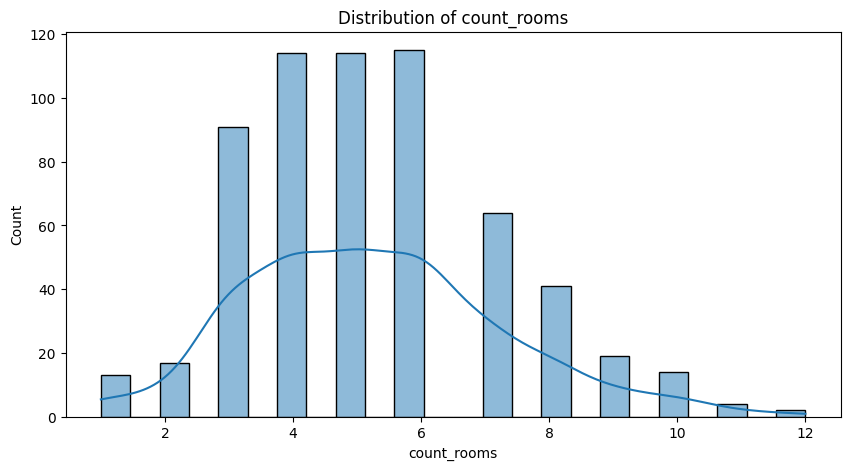


Summary statistics for count_rooms:
count    608.000000
mean       5.248355
std        2.003908
min        1.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: count_rooms, dtype: float64


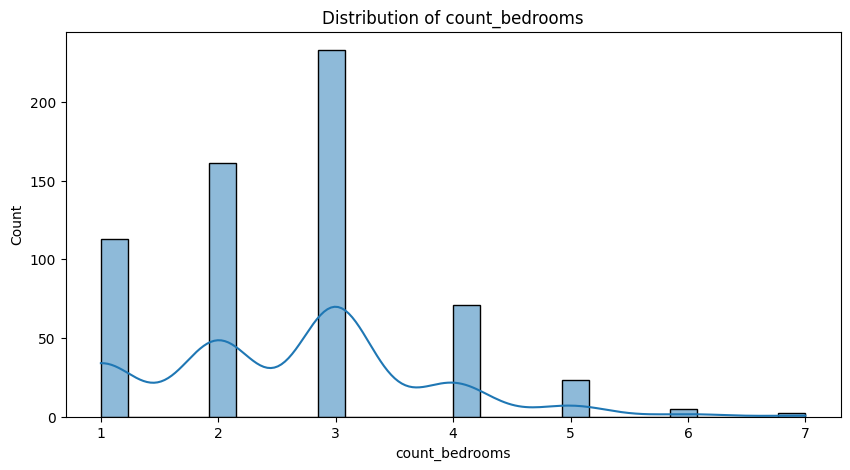


Summary statistics for count_bedrooms:
count    608.000000
mean       2.593750
std        1.113535
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        7.000000
Name: count_bedrooms, dtype: float64


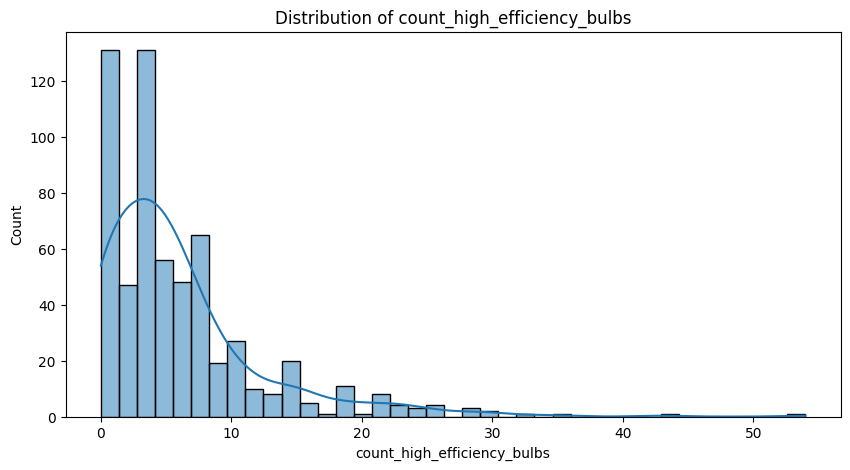


Summary statistics for count_high_efficiency_bulbs:
count    608.000000
mean       6.037829
std        6.447626
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       54.000000
Name: count_high_efficiency_bulbs, dtype: float64


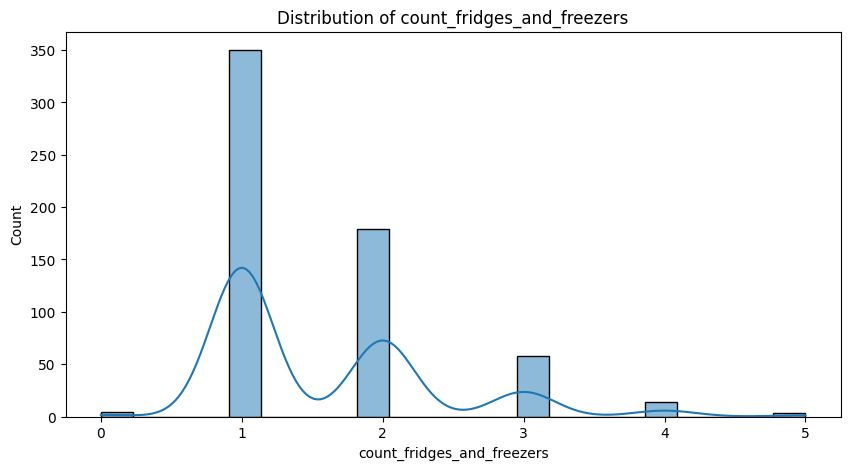


Summary statistics for count_fridges_and_freezers:
count    608.000000
mean       1.567434
std        0.804881
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: count_fridges_and_freezers, dtype: float64


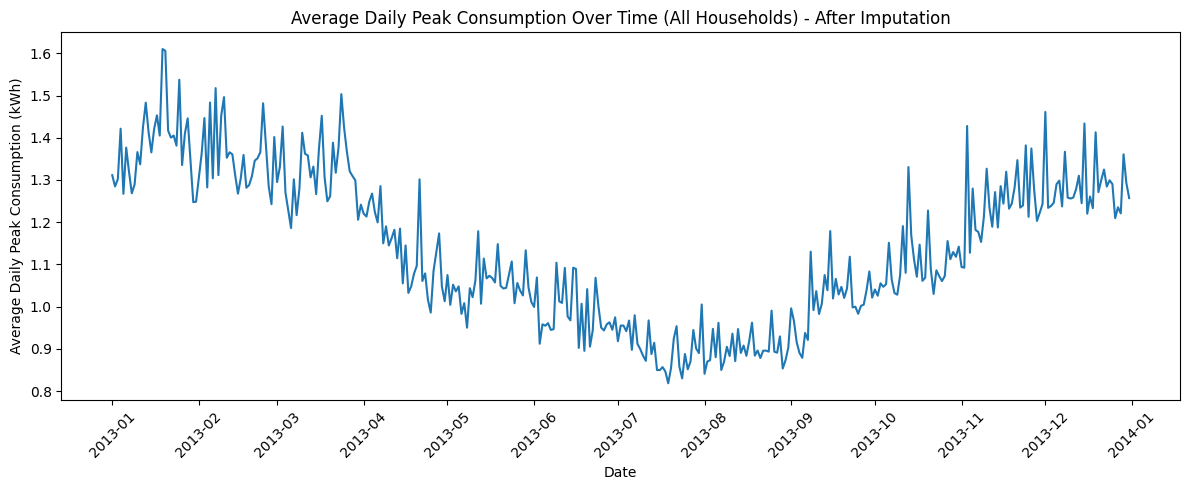

In [9]:
plot_and_summarize(df_households_imputed, vars_of_interest, "Post-processing")

# Merge the imputed static characteristics back into df_merged
df_merged_updated = df_merged.copy()
df_merged_updated.set_index('household_id', inplace=True)
df_households_imputed.set_index('household_id', inplace=True)
df_merged_updated.update(df_households_imputed)
df_merged_updated.reset_index(inplace=True)

# Recalculate daily peak consumption after imputation
daily_peak = df_merged_updated.groupby(['household_id', df_merged_updated['timestamp'].dt.date])['consumption'].max().reset_index()
avg_daily_peak = daily_peak.groupby('timestamp')['consumption'].mean()

# Post-imputation time series plot
plot_timeseries(avg_daily_peak.index, avg_daily_peak.values, 
                'Average Daily Peak Consumption Over Time (All Households) - After Imputation', 
                'Average Daily Peak Consumption (kWh)')

In [10]:
# Save the full imputed dataframe
df_merged_updated.to_csv('5) final_merged_data_imputed.csv', index=False)
print("\nFull imputed dataframe saved as '5) final_merged_data_imputed.csv'")


Full imputed dataframe saved as '5) final_merged_data_imputed.csv'
